In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

d:\MY FILES\IITB\Sem 3\DS203\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 5 10 12 14 16 18 23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
d:\MY FILES\IITB\Sem 3\DS203\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


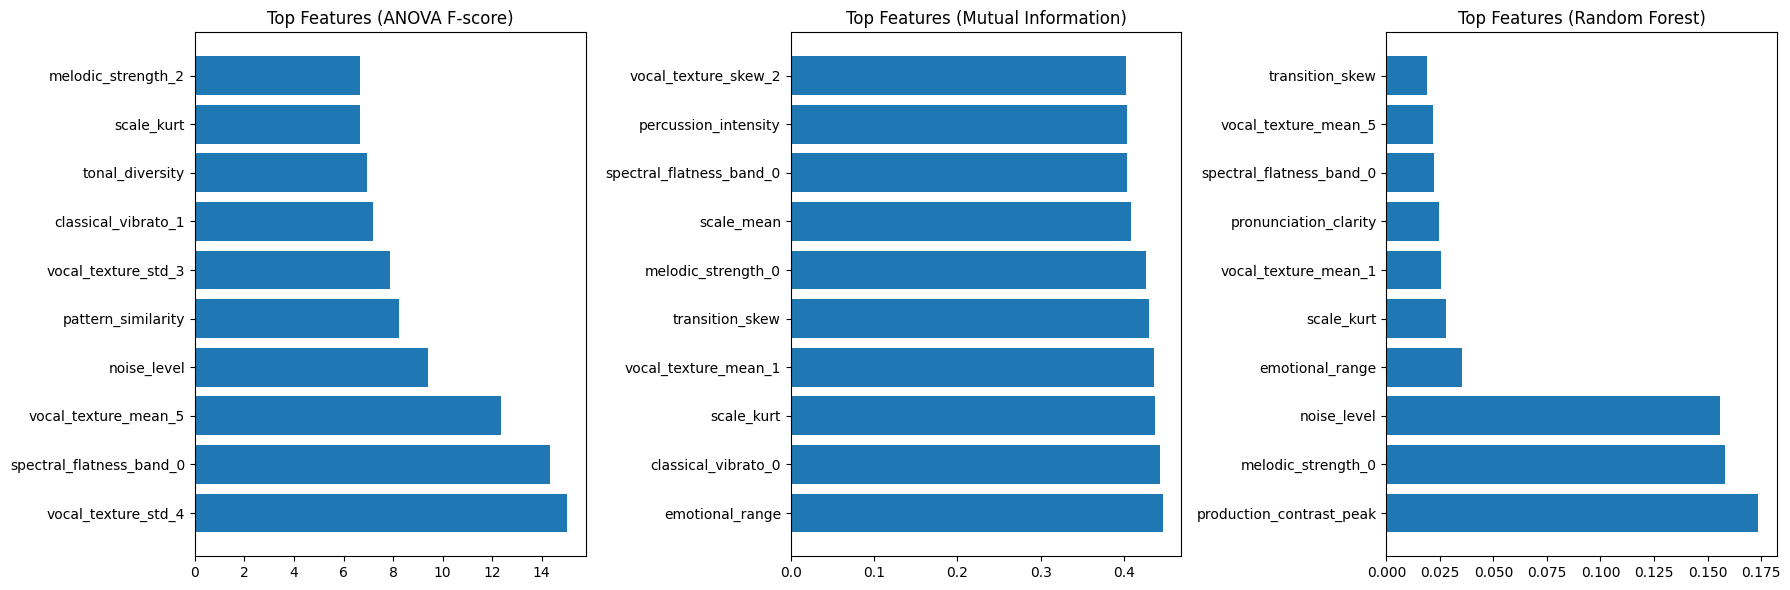


Top features by ANOVA F-test:
                     Feature    F_Score       P_value
42       vocal_texture_std_4  15.030461  1.591922e-10
19  spectral_flatness_band_0  14.357138  3.773650e-10
44      vocal_texture_mean_5  12.347443  5.508061e-09
22               noise_level   9.408979  3.782660e-07
7         pattern_similarity   8.233840  2.297673e-06

Top features by Mutual Information:
                 Feature  MI_Score
29       emotional_range  0.446560
13   classical_vibrato_0  0.442615
52            scale_kurt  0.437285
32  vocal_texture_mean_1  0.435464
48       transition_skew  0.430399

Top features by Random Forest Importance:
                     Feature  RF_Importance
53  production_contrast_peak       0.173805
0         melodic_strength_0       0.158295
22               noise_level       0.155692
29           emotional_range       0.035406
52                scale_kurt       0.027993

Top 10 combined features:
['scale_kurt', 'spectral_flatness_band_0', 'emotional_range', 'n

In [18]:
def analyze_features(X, y, feature_names, top_n=10):
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    results = {}
    
    # Method 1: ANOVA F-value
    f_selector = SelectKBest(score_func=f_classif, k='all')
    f_selector.fit(X_scaled, y)
    f_scores = pd.DataFrame({
        'Feature': feature_names,
        'F_Score': f_selector.scores_,
        'P_value': f_selector.pvalues_
    }).sort_values('F_Score', ascending=False)
    results['anova'] = f_scores
    
    # Method 2: Mutual Information
    mi_scores = mutual_info_classif(X_scaled, y)
    mi_results = pd.DataFrame({
        'Feature': feature_names,
        'MI_Score': mi_scores
    }).sort_values('MI_Score', ascending=False)
    results['mutual_info'] = mi_results
    
    # Method 3: Random Forest Feature Importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)
    rf_importance = pd.DataFrame({
        'Feature': feature_names,
        'RF_Importance': rf.feature_importances_
    }).sort_values('RF_Importance', ascending=False)
    results['random_forest'] = rf_importance
    
    # Combine rankings
    combined_scores = pd.DataFrame({
        'Feature': feature_names,
        'ANOVA_Rank': f_scores['F_Score'].rank(ascending=False),
        'MI_Rank': mi_results['MI_Score'].rank(ascending=False),
        'RF_Rank': rf_importance['RF_Importance'].rank(ascending=False)
    })
    combined_scores['Combined_Rank'] = combined_scores[['ANOVA_Rank', 'MI_Rank', 'RF_Rank']].mean(axis=1)
    combined_scores = combined_scores.sort_values('Combined_Rank')
    
    # Get top features
    top_features = combined_scores.head(top_n)['Feature'].tolist()
    results['combined'] = combined_scores
    results['top_features'] = top_features
    
    # Plot results
    plt.figure(figsize=(18, 6))
    
    # Top features by ANOVA F-score
    plt.subplot(131)
    top_f = f_scores.head(top_n)
    plt.barh(range(top_n), top_f['F_Score'])
    plt.yticks(range(top_n), top_f['Feature'])
    plt.title('Top Features (ANOVA F-score)')
    
    # Top features by Mutual Information
    plt.subplot(132)
    top_mi = mi_results.head(top_n)
    plt.barh(range(top_n), top_mi['MI_Score'])
    plt.yticks(range(top_n), top_mi['Feature'])
    plt.title('Top Features (Mutual Information)')
    
    # Top features by Random Forest
    plt.subplot(133)
    top_rf = rf_importance.head(top_n)
    plt.barh(range(top_n), top_rf['RF_Importance'])
    plt.yticks(range(top_n), top_rf['Feature'])
    plt.title('Top Features (Random Forest)')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Load labeled dataset
labeled_data = pd.read_csv('extracted_features.csv')

# Separate features and labels for labeled data
X_labeled = labeled_data.drop(columns=['label'])
y_labeled = labeled_data['label']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_labeled_imputed = imputer.fit_transform(X_labeled)

# Remove correlations in labeled data
correlation_matrix = pd.DataFrame(X_labeled_imputed, columns=X_labeled.columns).corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_correlation_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
X_labeled_dropped = pd.DataFrame(X_labeled_imputed, columns=X_labeled.columns).drop(columns=high_correlation_features)

# Analyze features
results = analyze_features(X_labeled_dropped, y_labeled, feature_names=X_labeled_dropped.columns, top_n=10)

# Print top features from each method
print("\nTop features by ANOVA F-test:")
print(results['anova'].head())

print("\nTop features by Mutual Information:")
print(results['mutual_info'].head())

print("\nTop features by Random Forest Importance:")
print(results['random_forest'].head())

print("\nTop 10 combined features:")
print(results['top_features'])

In [ ]:
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

def train_and_evaluate_classifiers(X_train, y_train, X_test, y_test, feature_names):

    # Initialize classifiers
    classifiers = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(kernel='rbf', probability=True, random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }
    
    results = {}
    
    # Train and evaluate each classifier
    for name, clf in classifiers.items():
        # Train the model
        clf.fit(X_train, y_train)
        
        # Make predictions
        y_pred = clf.predict(X_test)
        
        # Store results
        results[name] = {
            'model': clf,
            'accuracy': clf.score(X_test, y_test),
            'predictions': y_pred,
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        
        # Cross-validation score
        cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
        results[name]['cv_scores'] = cv_scores
        results[name]['cv_mean'] = cv_scores.mean()
        results[name]['cv_std'] = cv_scores.std()
    
    return results

def classify_unlabeled_data(unlabeled_data, selected_features, trained_model, scaler, imputer):

    # Select features and handle missing values
    X_unlabeled = unlabeled_data[selected_features].values
    X_unlabeled_imputed = imputer.transform(X_unlabeled)
    X_unlabeled_scaled = scaler.transform(X_unlabeled_imputed)
    
    # Make predictions
    predictions = trained_model.predict(X_unlabeled_scaled)
    
    # Create results DataFrame
    results_df = unlabeled_data.copy()
    results_df['Predicted_Category'] = predictions
    
    return results_df[['filename', 'Predicted_Category']]

# Main execution function
def main(labeled_data, unlabeled_data, selected_features, target_column):
    # Prepare labeled data
    selected_features = random.sample(selected_features, 5)
    X = labeled_data[selected_features].values
    
    # Encode target labels
    le = LabelEncoder()
    y = le.fit_transform(labeled_data[target_column])
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Train and evaluate models
    results = train_and_evaluate_classifiers(X_train, y_train, X_test, y_test, selected_features)
    
    # Select best model (based on cross-validation score)
    best_model_name = max(results.items(), key=lambda x: x[1]['cv_mean'])[0]
    best_model = results[best_model_name]['model']
    
    # Classify unlabeled data
    predictions_df = classify_unlabeled_data(
        unlabeled_data, selected_features, best_model, scaler, imputer
    )
    
    return predictions_df

# Load labeled dataset
labeled_data = pd.read_csv('extracted_features.csv')

# Load unlabeled dataset
unlabeled_data = pd.read_csv('MFCC-files-features.csv')

# Define selected features and target column
# Replace these with your actual feature names
selected_features = results['top_features']
target_column = 'label'

# Run the main function
predictions_df = main(
    labeled_data,
    unlabeled_data,
    selected_features,
    target_column
)

predictions_df.to_csv('predicted_unlabeled_data.csv', index=False)

d:\MY FILES\IITB\Sem 3\DS203\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\MY FILES\IITB\Sem 3\DS203\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\MY FILES\IITB\Sem 3\DS203\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
predictions_df

,filename,Predicted_Category
0,01-MFCC.csv,5
1,02-MFCC.csv,4
2,03-MFCC.csv,5
3,04-MFCC.csv,2
4,05-MFCC.csv,4
...,...,...
111,95-MFCC.csv,5
112,96-MFCC.csv,4
113,97-MFCC.csv,5
114,98-MFCC.csv,4


Now we checked these with listening to audio files and changed some Predicted Categories

In [28]:
updated_predictions_df = pd.read_csv('predicted_unlabeled_data.csv')
# This is updated file with some changes made while listening to audio files converted from mfcc coefficients

In [29]:
updated_predictions_df

,filename,Predicted_Category
0,01-MFCC.csv,4
1,02-MFCC.csv,4
2,03-MFCC.csv,3
3,04-MFCC.csv,2
4,05-MFCC.csv,1
...,...,...
111,95-MFCC.csv,4
112,96-MFCC.csv,1
113,97-MFCC.csv,1
114,98-MFCC.csv,2



Updated Predictions for unlabeled data:
      filename Predicted_Category
0  01-MFCC.csv     National Songs
1  02-MFCC.csv     National Songs
2  03-MFCC.csv    Michael Jackson
3  04-MFCC.csv        Asha Bhosle
4  05-MFCC.csv      Kishore Kumar


C:\Users\Ronak\AppData\Local\Temp\ipykernel_19364\1285044332.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


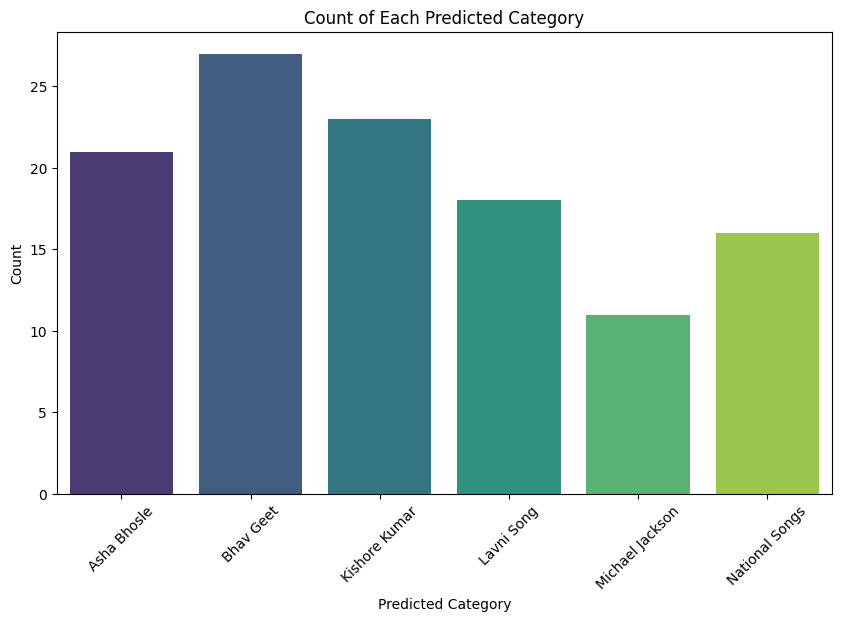

In [30]:
def replace_categories_with_labels(updated_predictions_df):

    category_mapping = {
        1: 'Kishore Kumar',
        2: 'Asha Bhosle',
        3: 'Michael Jackson',
        4: 'National Songs',
        5: 'Bhav Geet',
        6: 'Lavni Song'
    }
    
    updated_predictions_df['Predicted_Category'] = updated_predictions_df['Predicted_Category'].map(category_mapping)
    
    return updated_predictions_df

def plot_category_counts(updated_predictions_df):

    category_counts = updated_predictions_df['Predicted_Category'].value_counts().sort_index()
    
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
    plt.title("Count of Each Predicted Category")
    plt.xlabel("Predicted Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

updated_predictions_df = replace_categories_with_labels(updated_predictions_df)

print("\nUpdated Predictions for unlabeled data:")
print(updated_predictions_df.head())

plot_category_counts(updated_predictions_df)

# Save the updated predictions to a CSV file
updated_predictions_df.to_csv('predicted_unlabeled_data_with_labels.csv', index=False)